In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v8_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v8_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [3]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0,1,-1,0,1,-1,-1,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,212.0,364.0,40.0,3.0,1.0,1.0,4,6,8,11,335580,36215,13849,13529,881,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037868,0.036485
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0,2,-1,0,1,-1,-1,0,0,76.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,4,6,8,11,335580,36215,13849,13529,785,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041860,0.040170
2,000104bdffaaad1a1e0a9ebacf585f33,902,0,3,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,4,6,8,11,335580,36215,13849,13529,675,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041742,0.040073
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0,4,-1,0,1,-1,-1,0,0,111.0,1.0,0,1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,134.0,1114.0,143.0,16.0,12.0,12.0,4,6,8,11,335580,36215,13849,13529,671,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.032967,0.031939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,0,5,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,4,6,8,11,335580,36215,13849,13529,911,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037037,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.017964,0.017748
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.018450,0.018177
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.035605,0.034342,0.022624,0.022163
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b0

In [4]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


### CatBoost Ranker

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score
from catboost import CatBoostRanker, Pool

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad', 'TE_wid_cd', 'TE_ken_cd', 'TE_lrg_cd', 'TE_sml_cd', 'TE_yado_no', 'predict_no')] # seen_yadも入れる 
cat_cols = ['yado_no']+ ['label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd'] 
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

# CatBoost のパラメータ
params = {
    'loss_function': 'YetiRank',  # YetiRankPairwise という選択肢もあります
    'learning_rate': 0.2,
    'iterations': 10000,
    'depth': 6,
    'random_seed': 42531,
    "cat_features": cat_cols,
    'task_type': 'GPU',  # GPUを使用するための設定
}

In [7]:
map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # データセットの作成
    train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids], cat_features=cat_cols)
    val_pool = Pool(data=valid_data[features], label=valid_data[target], group_id=valid_data[query_ids], cat_features=cat_cols)

    # モデルの訓練
    model = CatBoostRanker(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(val_pool)
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存

    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')


Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1654257	best: 0.1654257 (0)	total: 120ms	remaining: 19m 56s
1:	test: 0.1865304	best: 0.1865304 (1)	total: 230ms	remaining: 19m 10s
2:	test: 0.1869639	best: 0.1869639 (2)	total: 340ms	remaining: 18m 51s
3:	test: 0.1872349	best: 0.1872349 (3)	total: 448ms	remaining: 18m 38s
4:	test: 0.1947026	best: 0.1947026 (4)	total: 559ms	remaining: 18m 37s
5:	test: 0.1949483	best: 0.1949483 (5)	total: 667ms	remaining: 18m 30s
6:	test: 0.1947478	best: 0.1949483 (5)	total: 777ms	remaining: 18m 28s
7:	test: 0.1956672	best: 0.1956672 (7)	total: 884ms	remaining: 18m 24s
8:	test: 0.1967433	best: 0.1967433 (8)	total: 994ms	remaining: 18m 23s
9:	test: 0.1998315	best: 0.1998315 (9)	total: 1.11s	remaining: 18m 27s
10:	test: 0.2021211	best: 0.2021211 (10)	total: 1.22s	remaining: 18m 28s
11:	test: 0.2051691	best: 0.2051691 (11)	total: 1.33s	remaining: 18m 26s
12:	test: 0.2061278	best: 0.2061278 (12)	total: 1.44s	remaining: 18m 25s
13:	test: 0.2077273	best: 0.2077273 (13)	total: 1.55s	remaining: 18m 23

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1670309	best: 0.1670309 (0)	total: 128ms	remaining: 21m 18s
1:	test: 0.1729008	best: 0.1729008 (1)	total: 252ms	remaining: 21m 1s
2:	test: 0.1866704	best: 0.1866704 (2)	total: 371ms	remaining: 20m 37s
3:	test: 0.1928479	best: 0.1928479 (3)	total: 487ms	remaining: 20m 16s
4:	test: 0.1976307	best: 0.1976307 (4)	total: 604ms	remaining: 20m 7s
5:	test: 0.1988093	best: 0.1988093 (5)	total: 718ms	remaining: 19m 56s
6:	test: 0.2002400	best: 0.2002400 (6)	total: 834ms	remaining: 19m 50s
7:	test: 0.2036471	best: 0.2036471 (7)	total: 948ms	remaining: 19m 44s
8:	test: 0.2049872	best: 0.2049872 (8)	total: 1.06s	remaining: 19m 39s
9:	test: 0.2055960	best: 0.2055960 (9)	total: 1.18s	remaining: 19m 36s
10:	test: 0.2056924	best: 0.2056924 (10)	total: 1.29s	remaining: 19m 35s
11:	test: 0.2067895	best: 0.2067895 (11)	total: 1.41s	remaining: 19m 33s
12:	test: 0.2099535	best: 0.2099535 (12)	total: 1.53s	remaining: 19m 35s
13:	test: 0.2100442	best: 0.2100442 (13)	total: 1.64s	remaining: 19m 33s


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1650216	best: 0.1650216 (0)	total: 113ms	remaining: 18m 53s
1:	test: 0.1739306	best: 0.1739306 (1)	total: 227ms	remaining: 18m 53s
2:	test: 0.1748121	best: 0.1748121 (2)	total: 335ms	remaining: 18m 36s
3:	test: 0.1782849	best: 0.1782849 (3)	total: 444ms	remaining: 18m 29s
4:	test: 0.1796606	best: 0.1796606 (4)	total: 553ms	remaining: 18m 24s
5:	test: 0.1809394	best: 0.1809394 (5)	total: 662ms	remaining: 18m 22s
6:	test: 0.1871249	best: 0.1871249 (6)	total: 768ms	remaining: 18m 15s
7:	test: 0.1880526	best: 0.1880526 (7)	total: 874ms	remaining: 18m 12s
8:	test: 0.1882882	best: 0.1882882 (8)	total: 979ms	remaining: 18m 6s
9:	test: 0.1975789	best: 0.1975789 (9)	total: 1.09s	remaining: 18m 5s
10:	test: 0.1975215	best: 0.1975789 (9)	total: 1.19s	remaining: 18m 3s
11:	test: 0.1981812	best: 0.1981812 (11)	total: 1.3s	remaining: 18m 5s
12:	test: 0.1989029	best: 0.1989029 (12)	total: 1.41s	remaining: 18m 4s
13:	test: 0.2026876	best: 0.2026876 (13)	total: 1.52s	remaining: 18m 6s
14:	te

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1627799	best: 0.1627799 (0)	total: 115ms	remaining: 19m 13s
1:	test: 0.1758011	best: 0.1758011 (1)	total: 223ms	remaining: 18m 36s
2:	test: 0.1832926	best: 0.1832926 (2)	total: 331ms	remaining: 18m 23s
3:	test: 0.1830082	best: 0.1832926 (2)	total: 436ms	remaining: 18m 8s
4:	test: 0.1879279	best: 0.1879279 (4)	total: 540ms	remaining: 17m 59s
5:	test: 0.1882917	best: 0.1882917 (5)	total: 645ms	remaining: 17m 54s
6:	test: 0.1889703	best: 0.1889703 (6)	total: 750ms	remaining: 17m 51s
7:	test: 0.1974124	best: 0.1974124 (7)	total: 856ms	remaining: 17m 49s
8:	test: 0.2026638	best: 0.2026638 (8)	total: 966ms	remaining: 17m 51s
9:	test: 0.2055802	best: 0.2055802 (9)	total: 1.07s	remaining: 17m 51s
10:	test: 0.2057337	best: 0.2057337 (10)	total: 1.19s	remaining: 17m 57s
11:	test: 0.2065269	best: 0.2065269 (11)	total: 1.3s	remaining: 18m 1s
12:	test: 0.2077787	best: 0.2077787 (12)	total: 1.41s	remaining: 18m 2s
13:	test: 0.2080060	best: 0.2080060 (13)	total: 1.51s	remaining: 18m
14:	te

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1801602	best: 0.1801602 (0)	total: 122ms	remaining: 20m 18s
1:	test: 0.1818897	best: 0.1818897 (1)	total: 238ms	remaining: 19m 50s
2:	test: 0.1922900	best: 0.1922900 (2)	total: 349ms	remaining: 19m 22s
3:	test: 0.1984621	best: 0.1984621 (3)	total: 464ms	remaining: 19m 19s
4:	test: 0.1985978	best: 0.1985978 (4)	total: 576ms	remaining: 19m 12s
5:	test: 0.1986876	best: 0.1986876 (5)	total: 689ms	remaining: 19m 6s
6:	test: 0.2017285	best: 0.2017285 (6)	total: 800ms	remaining: 19m 1s
7:	test: 0.2047654	best: 0.2047654 (7)	total: 910ms	remaining: 18m 56s
8:	test: 0.2084041	best: 0.2084041 (8)	total: 1.03s	remaining: 18m 59s
9:	test: 0.2110360	best: 0.2110360 (9)	total: 1.14s	remaining: 18m 56s
10:	test: 0.2112423	best: 0.2112423 (10)	total: 1.25s	remaining: 18m 54s
11:	test: 0.2115875	best: 0.2115875 (11)	total: 1.36s	remaining: 18m 51s
12:	test: 0.2135608	best: 0.2135608 (12)	total: 1.47s	remaining: 18m 48s
13:	test: 0.2135134	best: 0.2135608 (12)	total: 1.58s	remaining: 18m 46s


              Feature Id  Importances
0          count_yado_no     0.015219
1            sml_cd_rank     0.008821
2            lrg_cd_rank     0.008742
3          TE_ken_cd_var     0.008701
4                yado_no     0.008328
5             max_seq_no     0.006744
6        TE_yado_no_mean     0.001811
7         total_room_cnt     0.000704
8         TE_yado_no_var     0.000365
9            wid_cd_rank     0.000326
10             onsen_flg     0.000302
11           ken_cd_rank     0.000202
12        TE_ken_cd_mean     0.000183
13           kd_stn_5min     0.000128
14        TE_lrg_cd_mean     0.000123
15         TE_wid_cd_var     0.000117
16          count_ken_cd     0.000102
17      wireless_lan_flg     0.000073
18          count_sml_cd     0.000061
19     kd_conv_walk_5min     0.000043
20          count_wid_cd     0.000040
21          label_sml_cd     0.000040
22        TE_wid_cd_mean     0.000032
23           kd_bch_5min     0.000031
24          count_lrg_cd     0.000019
25          

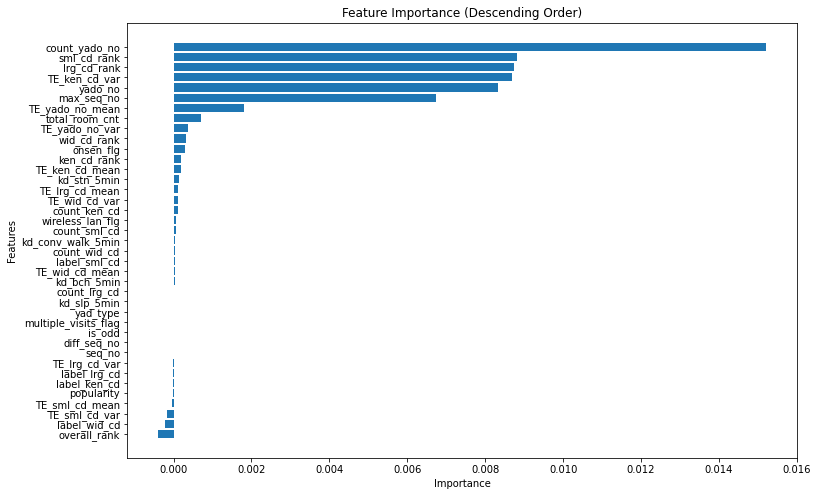

In [8]:
import matplotlib.pyplot as plt

# トレーニングデータセットでのPoolを作成（もしまだ作成していない場合）
#train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids])

# 特徴量の重要度を取得（トレーニングデータセットを使用）
feature_importances = model.get_feature_importance(train_pool, prettified=True)

# 特徴量の重要度を降順に並び替え
feature_importances.sort_values(by='Importances', ascending=False, inplace=True)

# 特徴量の重要度を表示
print(feature_importances)

# 特徴量の重要度をグラフで表示（降順）
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.gca().invert_yaxis()  # y軸を逆順にして、重要度が高い特徴量を上に表示
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Descending Order)')
plt.show()



In [9]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [10]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.279786
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.457193
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.235397
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.091200
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-1.187334


In [11]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.279786
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.457193
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.235397
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.091200
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-1.187334
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.607314
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-1.902104
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.212225
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.406979


In [12]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.279786
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.457193
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.235397
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.091200
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-1.187334
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.607314
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-1.902104
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.212225
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.406979


In [13]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/catRanker_ver6_oof_pred.csv', index=False)

In [14]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.279786
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.457193
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.235397
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.091200
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-1.187334
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.607314
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-1.902104
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.212225
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.406979


### CVの計算

In [15]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [16]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [17]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 902, 12491, 11380, 1284, 4072, 7749, 254, 5490]
CPU times: user 151 ms, sys: 7.9 ms, total: 159 ms
Wall time: 158 ms


In [18]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:47<00:00, 6058.55it/s]


In [19]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,997,12846,3324,5289,11882,9208,9207,9209
1,8253,2570,4488,8747,11104,1586,2259,3725,8225,3564
2,4863,5238,1967,13642,2957,9039,4355,6722,11724,7509
3,626,2272,13549,755,11715,109,1341,7812,7872,13296
4,96,3894,902,12491,11380,1284,4072,7749,254,5490
...,...,...,...,...,...,...,...,...,...,...
288693,10955,5719,10522,13079,3725,13210,1586,13717,8677,2876
288694,4767,963,513,2900,5299,8465,8703,6654,399,3940
288695,3566,4398,9558,2087,7820,7308,4040,12240,10364,844
288696,10619,570,7551,12500,3238,11091,12781,12829,10616,11316


### 要素の集合にバグがないかを確認

In [20]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [22]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムを確認する

In [23]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [24]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0         True
1         True
2         True
3         True
4         True
          ... 
288693    True
288694    True
288695    True
288696    True
288697    True
Length: 288698, dtype: bool
一致していない行：
288679


In [25]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [26]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,997,12846,3324,5289,11882,9208,9207,9209
1,8253,2570,4488,8747,11104,1586,2259,3725,8225,3564
2,4863,5238,1967,13642,2957,9039,4355,6722,11724,7509
3,626,2272,13549,755,11715,109,1341,7812,7872,13296
4,96,3894,902,12491,11380,1284,4072,7749,254,5490
5,4823,12544,10510,5369,9199,9207,9201,9202,9200,1
6,4574,7531,12774,10378,10442,2480,2282,441,7273,13240
7,111,10362,4744,12464,9508,12962,12125,10544,7681,1755
8,899,3802,3644,1227,4014,13220,12432,9723,13702,2164
9,10478,3483,379,550,4303,3278,6592,2806,9773,9430


In [54]:
train_label.head(20)

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96
5,00011afe25c343301ee961b3b0ce2e4d,4823
6,000125c737df1802b6e365f93c96d3c8,10378
7,0001763050a10b21062a1304fb743fd4,10362
8,000178c4d4d567d4715331dd0cdab76c,1227
9,0001e6a407a85dc50ac132a5c7016bab,175


In [27]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [28]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [29]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.4536830765207823


In [30]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [31]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [32]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,4101,2808,997,12846,3324,5289,11882,9208,9207,9209,False
1,8253,2570,4488,8747,11104,1586,2259,3725,8225,3564,False
2,4863,5238,1967,13642,2957,9039,4355,6722,11724,7509,False
3,626,2272,13549,755,11715,109,1341,7812,7872,13296,False
4,96,3894,902,12491,11380,1284,4072,7749,254,5490,False


### 推論用の候補テーブルを作成する

In [33]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [34]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[ 0.04751634 -0.87507687  0.3837889  ...  0.09297308 -0.03496904
  0.09862459]
1683604


In [35]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(5, 1683604)


In [36]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [37]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.047516
1,00001149e9c73985425197104712478c,4714,-0.875077
2,00001149e9c73985425197104712478c,2680,0.383789
3,00001149e9c73985425197104712478c,4420,-0.446144
4,00001149e9c73985425197104712478c,5466,-0.040884


In [38]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.047516
1,00001149e9c73985425197104712478c,4714,-0.875077
2,00001149e9c73985425197104712478c,2680,0.383789
3,00001149e9c73985425197104712478c,4420,-0.446144
4,00001149e9c73985425197104712478c,5466,-0.040884
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.258189
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.158445
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.092973
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.034969


In [39]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.047516
1,00001149e9c73985425197104712478c,4714,-0.875077
2,00001149e9c73985425197104712478c,2680,0.383789
3,00001149e9c73985425197104712478c,4420,-0.446144
4,00001149e9c73985425197104712478c,5466,-0.040884
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.258189
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.158445
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.092973
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.034969


In [40]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.047516
1,00001149e9c73985425197104712478c,4714,-0.875077
2,00001149e9c73985425197104712478c,2680,0.383789
3,00001149e9c73985425197104712478c,4420,-0.446144
4,00001149e9c73985425197104712478c,5466,-0.040884
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.258189
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.158445
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.092973
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.034969


In [41]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/catRanker_ver6_test_pred.csv', index=False)

In [42]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [43]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[5623, 11723, 10729, 3781, 1891, 12620, 11994, 12767, 867, 634]
CPU times: user 93 ms, sys: 3.99 ms, total: 97 ms
Wall time: 96.6 ms


In [44]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:30<00:00, 5816.01it/s]


In [45]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,9830,2680,11561,5466,9534,4420,4714,6563,5785
1,7014,11923,8108,613,143,6555,4066,6129,12862,11237
2,757,9190,9910,410,6730,1774,13570,6721,7710,10485
3,12341,3359,6991,10861,6489,10746,5080,4180,1542,13521
4,10826,9623,9020,2862,3476,3854,12029,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,11123,7062,2278,5744,3440,10042,10997,9743
174696,1227,899,3802,13702,4014,9723,13220,3644,12432,2164
174697,12939,7308,13719,11037,11796,13797,2087,8143,5810,13241
174698,2692,2373,4976,10287,1687,3100,13672,3002,5513,12281


In [46]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [47]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [48]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [49]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)

0


In [50]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [51]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,9830,2680,11561,5466,9534,4420,4714,6563,5785,False
1,7014,11923,8108,613,143,6555,4066,6129,12862,11237,False
2,757,9190,9910,410,6730,1774,13570,6721,7710,10485,False
3,12341,3359,6991,10861,6489,10746,5080,4180,1542,13521,False
4,10826,9623,9020,2862,3476,3854,12029,3844,5372,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,11123,7062,2278,5744,3440,10042,10997,9743,False
174696,1227,899,3802,13702,4014,9723,13220,3644,12432,2164,False
174697,12939,7308,13719,11037,11796,13797,2087,8143,5810,13241,False
174698,2692,2373,4976,10287,1687,3100,13672,3002,5513,12281,False


In [52]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/catRanker_ver6.csv', index=False)